# Cryptocurrency prediction - DEMO

This is a simple demo for cryptocurrency prediction based on daily data. It does not work, so don't blame me if you lose your money.

Created by [Judit Acs](https://github.com/juditacs)

[Data source on kaggle.com](https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense, Bidirectional, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.callbacks import EarlyStopping

import numpy as np

Using TensorFlow backend.


In [2]:
os.listdir("data/cryptocurrency/")

['bitcoin_cash_price.csv',
 'bitcoin_dataset.csv',
 'bitcoin_price.csv',
 'bitconnect_price.csv',
 'dash_price.csv',
 'ethereum_classic_price.csv',
 'ethereum_dataset.csv',
 'ethereum_price.csv',
 'iota_price.csv',
 'litecoin_price.csv',
 'monero_price.csv',
 'nem_price.csv',
 'neo_price.csv',
 'numeraire_price.csv',
 'omisego_price.csv',
 'qtum_price.csv',
 'ripple_price.csv',
 'stratis_price.csv',
 'waves_price.csv']

# Load data

We load each currency into a separate dataframe and store the dataframes in a dictionary.

In [3]:
coin_dataframes = {}

def convert_comma_int(field):
    try:
        return int(field.replace(',', ''))
    except ValueError:
        return None
    
for fn in os.listdir("data/cryptocurrency/"):
    if "bitcoin_cache" in fn:
        continue
    if fn.endswith("_price.csv"):
        coin_name = fn.split("_")[0]
        df = pd.read_csv(os.path.join("data", "cryptocurrency", fn), parse_dates=["Date"])
        df['Market Cap'] = df['Market Cap'].map(convert_comma_int)
        coin_dataframes[coin_name] = df.sort_values('Date')

In [4]:
coin_dataframes.keys()

dict_keys(['bitcoin', 'bitconnect', 'dash', 'ethereum', 'iota', 'litecoin', 'monero', 'nem', 'neo', 'numeraire', 'omisego', 'qtum', 'ripple', 'stratis', 'waves'])

Each dataframe looks like this:

In [5]:
coin_dataframes['nem'].head()

,Date,Open,High,Low,Close,Volume,Market Cap
916,2015-04-01,0.000400,0.000458,0.000170,0.000242,"65,525",3604110
915,2015-04-02,0.000242,0.000323,0.000227,0.000314,"28,549",2179320
914,2015-04-03,0.000309,0.000330,0.000291,0.000310,"20,678",2778750
913,2015-04-04,0.000310,0.000318,0.000251,0.000277,"23,550",2792120
912,2015-04-05,0.000272,0.000283,0.000218,0.000232,"26,800",2443720


## Bitcoin value growth

Just for fun.

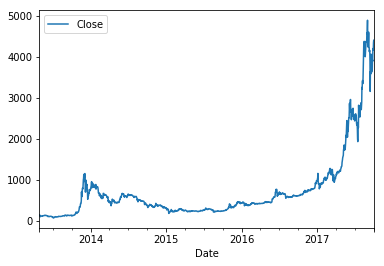

In [6]:
coin_dataframes['bitcoin'].plot(x='Date', y='Close')

# Compute relative growth and other relative values

We add these values as new columns to the dataframes:

In [7]:
def add_relative_columns(df):
    day_diff = df['Close'] - df['Open']
    df['rel_close'] = day_diff / df['Open']
    df['high_low_ratio'] = df['High'] / df['Low']
    df['rel_high'] = df['High'] / df['Close']
    df['rel_low'] = df['Low'] / df['Close']
    
    
for df in coin_dataframes.values():
    add_relative_columns(df)
    
coin_dataframes["nem"].head()

,Date,Open,High,Low,Close,Volume,Market Cap,rel_close,high_low_ratio,rel_high,rel_low
916,2015-04-01,0.000400,0.000458,0.000170,0.000242,"65,525",3604110,-0.395000,2.694118,1.892562,0.702479
915,2015-04-02,0.000242,0.000323,0.000227,0.000314,"28,549",2179320,0.297521,1.422907,1.028662,0.722930
914,2015-04-03,0.000309,0.000330,0.000291,0.000310,"20,678",2778750,0.003236,1.134021,1.064516,0.938710
913,2015-04-04,0.000310,0.000318,0.000251,0.000277,"23,550",2792120,-0.106452,1.266932,1.148014,0.906137
912,2015-04-05,0.000272,0.000283,0.000218,0.000232,"26,800",2443720,-0.147059,1.298165,1.219828,0.939655


## Create historical training data

The history tables will have values for the last 10 days for each day.

In [8]:
def create_history_frames(coin_dataframes):
    history_frames = {}
    for coin_name, df in coin_dataframes.items():
        history_frames[coin_name], x_cols = create_history_frame(df)
    return history_frames, x_cols
        

def create_history_frame(df):
    feature_cols = ['rel_close', 'rel_high', 'rel_low', 'high_low_ratio']
    y_col = ['rel_close']
    x_cols = []
    days = 10
    history = df[['Date'] + y_col].copy()
    for n in range(1, days+1):
        for feat_col in feature_cols:
            colname = '{}_{}'.format(feat_col, n)
            history[colname] = df[feat_col].shift(n)
            x_cols.append(colname)
    history = history[days:]
    return history, x_cols

y_col = 'rel_close'
coin_history, x_cols = create_history_frames(coin_dataframes)

# Define model

We will train a separate model for each currency. The models' architecture  identical.

In [9]:
def create_model():
    input_layer = Input(batch_shape=(None, len(x_cols), 1))
    layer = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
    layer = Bidirectional(LSTM(128))(layer)
    out = Dense(1, activation="sigmoid")(layer)
    m = Model(inputs=input_layer, outputs=out)
    m.compile("rmsprop", loss='mean_squared_error')
    return m

def create_train_test_mtx(history):
    X = history[x_cols].as_matrix()
    y = history[y_col].as_matrix()
    X = X.reshape(X.shape[0], X.shape[1], 1)
    rand_mtx = np.random.permutation(X.shape[0])
    train_split = int(X.shape[0] * 0.9)
    train_indices = rand_mtx[:train_split]
    test_indices = rand_mtx[train_split:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

def train_model(model, X, y):
    ea = EarlyStopping(monitor='val_loss', patience=2)
    val_loss = model.fit(X, y, epochs=500, batch_size=64, callbacks=[ea], verbose=0, validation_split=.1)
    return val_loss

## Train a model for each currency

We save RMSE as well as the predictions on each test set.

In [10]:
rmse = {}
pred = {}
test = {}

for coin_name, history in coin_history.items():
    model = create_model()
    X_train, X_test, y_train, y_test = create_train_test_mtx(history)
    train_model(model, X_train, y_train)
    test[coin_name] = y_test
    
    # run prediction on test set
    pred[coin_name] = model.predict(X_test)
    # compute test loss
    rmse[coin_name] = np.sqrt(np.mean((pred[coin_name] - y_test)**2))
    print(coin_name, rmse[coin_name])

bitcoin 0.0395829767904
bitconnect 0.105878993163
dash 0.067239614115
ethereum 0.0779520952451
iota 0.116951050119
litecoin 0.120207499218
monero 0.05655138178
nem 0.0749458345141
neo 0.081203570008
numeraire 0.143091012434
omisego 0.100255266302
qtum 0.0939036685546
ripple 0.165650145426
stratis 0.103679609164
waves 0.0830779387789


## Do our models predict the signum of the value change correctly?

In [13]:
pred_sign = {coin_name: np.sign(pred[coin_name]) * np.sign(test[coin_name]) for coin_name in pred.keys()}
for coin, val in sorted(pred_sign.items()):
    cnt = np.unique(pred_sign[coin], return_counts=True)[1]
    print("[{}] pos/neg change guessed correctly: {}, incorrectly: {}, correct%: {}".format(
        coin, cnt[0], cnt[1], cnt[0]/ (cnt[0]+cnt[1]) * 100))

[bitcoin] pos/neg change guessed correctly: 11914, incorrectly: 14007, correct%: 45.962732919254655
[bitconnect] pos/neg change guessed correctly: 350, incorrectly: 275, correct%: 56.00000000000001
[dash] pos/neg change guessed correctly: 7524, incorrectly: 396, correct%: 95.0
[ethereum] pos/neg change guessed correctly: 3120, incorrectly: 2964, correct%: 51.28205128205128
[iota] pos/neg change guessed correctly: 66, incorrectly: 55, correct%: 54.54545454545454
[litecoin] pos/neg change guessed correctly: 13041, incorrectly: 1449, correct%: 90.0
[monero] pos/neg change guessed correctly: 6765, incorrectly: 8364, correct%: 44.71544715447154
[nem] pos/neg change guessed correctly: 4914, incorrectly: 3367, correct%: 59.34065934065934
[neo] pos/neg change guessed correctly: 760, incorrectly: 684, correct%: 52.63157894736842
[numeraire] pos/neg change guessed correctly: 50, incorrectly: 50, correct%: 50.0
[omisego] pos/neg change guessed correctly: 16, incorrectly: 48, correct%: 25.0
[qtum]

## Did we guess anything useful at all?

In [12]:
pred_sign = {coin_name: np.sign(pred[coin_name]) for coin_name in pred.keys()}
for coin, val in sorted(pred_sign.items()):
    e, cnt = np.unique(val, return_counts=True)
    print("[{}] guesses: {}".format(coin, dict(zip(e, cnt))))

[bitcoin] guesses: {1.0: 161}
[bitconnect] guesses: {1.0: 25}
[dash] guesses: {1.0: 132}
[ethereum] guesses: {1.0: 78}
[iota] guesses: {1.0: 11}
[litecoin] guesses: {1.0: 161}
[monero] guesses: {1.0: 123}
[nem] guesses: {1.0: 91}
[neo] guesses: {1.0: 38}
[numeraire] guesses: {1.0: 10}
[omisego] guesses: {1.0: 8}
[qtum] guesses: {1.0: 13}
[ripple] guesses: {1.0: 152}
[stratis] guesses: {1.0: 41}
[waves] guesses: {1.0: 48}
